<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Задача-проекта" data-toc-modified-id="Задача-проекта-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Задача проекта</a></span></li><li><span><a href="#Цель-проекта" data-toc-modified-id="Цель-проекта-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Цель проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Описание данных</a></span></li></ul></li><li><span><a href="#Загрузка-и-изучение-данных" data-toc-modified-id="Загрузка-и-изучение-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и изучение данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Разработка алгоритма сервиса упаковщика для Яндекс Маркета

## Описание проекта

Компания заметила, что сотрудник тратит большое количество времени для выбора упаковочного материала, в которы необходимо упаковать товары. Существует большое количество упаковочного материала (коробочки, пакетики). Необходимо придумать способ подсказывать пользователю информацию о выборе упаковочного материала.

### Задача проекта

Необходимо придумать способ подсказывать пользователю информацию о выборе упаковочного материала, а также разработать интерфейс для упаковщика.

### Цель проекта

Необходимо с высокой точностью рекомендовать правильную упаковку для заказа, которая позволит доставить товары без порчи клиенту и минимизирует затраты на упаковочный материал.

 ### Описание данных
    
<b/>Заказы (data.csv) - Информация по заказам и товарам (sku), которые в них содержатся</b>
    
- whs - код сортировочного центра;
- orderkey - id заказа;
- selected_cartontype - код упаковки, которая была выбрана пользователем;
- box_num - количество коробок;
- recommended_cartontype - код упаковки, рекомендованной алгоритмом;
- selected_carton - код упаковки, которая была выбрана пользователем (дубль);
- sel_calc_cube - объём выбранной упаковки;
- recommended_carton - код упаковки, рекомендованной алгоритмом (дубль);
- pack_volume - рассчитанный объём упакованных товаров;
- goods_wght - вес товара;
- sku - id товара;
- who - упаковщик;
- trackingid - id доставки;
    
<b/>SKU (sku.csv) - Выгрузка id товаров и их размеров.</b>
    
- sku - id товара
- a, b, c, - размеры
    
<b/>Карготипы товаров (sku_cargotypes.csv) - Выгрузка id товаров и их карготипов.</b>
    
- sku -  id товара
- cargotype - карготип товара
    
<b/>Описание карготипов (cargotype_info.csv) - Таблица с идентификаторами карготипов и их описаниями</b>
    
- cargotype -  карготип
- description - описание
    
<b/>Характеристики упаковок (carton.csv) - Таблица с идентификаторами и линейными размерами упаковок.</b>
    
- CARTONTYPE - идентификатор (код) упаковки;
- LENGTH, WIDTH, HEIGTH - линейные размеры упаковки;
- DISPLAYFRACK - коробка есть на складе (не учитывать для наших целей).
    
<b/>Стоимость упаковок (carton_price.xlsx) - Таблица с идентификаторами упаковок и их стоимостью.</b>
    
- идентификатор (код) упаковки
- стоимость

## Загрузка и изучение данных

In [1]:
#загрузим необходимые библиотеки

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import phik
import pickle
import seaborn as sns
import joblib
import warnings

from lightgbm import LGBMClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    multilabel_confusion_matrix,
    classification_report
)
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler
)

from pickle import load

# натроим некоторые параметры
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

#зададим константу
RANDOM_STATE = 42

In [2]:
#создадим функцию для загрузки датасета
def read_df(df):
    if os.path.exists(df):
        df_raw = pd.read_csv(df, index_col=0)
        print('ok')
        return df_raw
    return print('error')

In [3]:
#загрузим все датасеты
data = read_df('data.csv')
cargotype_info = read_df('cargotype_info.csv')
carton = read_df('carton.csv')
carton_price = read_df('carton_price.csv')
sku = read_df('sku.csv')
sku_cargotypes = read_df('sku_cargotypes.csv')

ok
ok
ok
ok
ok
ok


In [4]:
#создадим функцию для вывода обзорного отчета по данным
def mini_report(df):
    print('Head')
    display(df.head())
    print('')
    print('Describe')
    display(df.describe())
    print('')
    display(df.info())
    print('Всего пропущенных значений %', 
          pd.DataFrame(df.isna().mean()*100).sum())

In [5]:
# выведем отчет по первому датасету
mini_report(data)

Head


,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24



Describe


,whs,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght
count,325623.000000,325623.000000,325623.000000,3.256230e+05,325623.000000,325623.000000
mean,1.366166,2.787773,11188.402656,5.440790e+03,18253.646168,1.134705
std,2.098641,15.774209,13958.516542,2.858190e+04,26745.365119,4.090043
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,1.000000,3449.000000,5.000000e+02,3449.000000,0.110000
50%,0.000000,1.000000,8436.000000,1.192000e+03,8525.000000,0.300000
75%,3.000000,1.000000,15579.000000,3.154000e+03,18270.000000,0.799000
max,7.000000,235.000000,108000.000000,1.815450e+06,108000.000000,153.700000



<class 'pandas.core.frame.DataFrame'>
Index: 325623 entries, 0 to 325622
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   whs                     325623 non-null  int64  
 1   orderkey                325623 non-null  object 
 2   selected_cartontype     325623 non-null  object 
 3   box_num                 325623 non-null  int64  
 4   recommended_cartontype  325623 non-null  object 
 5   selected_carton         325623 non-null  object 
 6   sel_calc_cube           325623 non-null  int64  
 7   recommended_carton      325623 non-null  object 
 8   pack_volume             325623 non-null  int64  
 9   rec_calc_cube           325623 non-null  int64  
 10  goods_wght              325623 non-null  float64
 11  sku                     325623 non-null  object 
 12  who                     325623 non-null  object 
 13  trackingid              325623 non-null  object 
dtypes: float64(1), int64(5),

None

Всего пропущенных значений % 0    0.0
dtype: float64


In [6]:
# проверим количество уникальных значений
len(data['trackingid'].unique())

170565

In [7]:
# проверим количество уникальных значений
len(data['orderkey'].unique())

159899

In [8]:
#посмотрим на данные в столбце whs
data['whs'].value_counts()

whs
0    203685
4     31990
3     28345
7     16987
1     16963
2     16611
6      7556
5      3486
Name: count, dtype: int64

В таблице data встречаются дубликаты столбцов, можно удалить selected_carton и recommended_carton. Столбец whs - код сортировочного центра, можно удалить. Пропусков нет. В столбце orderkey встречаются дублирубщиеся ключи. Поскольку в одном заказе есть несколько товаров, сами товары могут повторяться, никакие дубликаты удаляться не будут. С типами данных проблем нет. 

In [9]:
# выведем отчет по второму датасету
mini_report(carton_price)

Head


,Unnamed: 0,01.03.2023
0,MYA,1.109861
1,MYB,2.297432
2,MYC,3.616713
3,MYD,6.918375
4,MYE,8.062722



Describe


,01.03.2023
count,15.000000
mean,14.067584
std,12.921889
min,1.109861
25%,4.238034
50%,8.062722
75%,20.568314
max,40.911178



<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  15 non-null     object 
 1   01.03.2023  15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 360.0+ bytes


None

Всего пропущенных значений % 0    0.0
dtype: float64


In [10]:
# посмотрим на уникальные значения
carton_price['Unnamed: 0'].unique()

array(['MYA', 'MYB', 'MYC', 'MYD', 'MYE', 'MYF', 'YMA', 'YMC', 'YME',
       'YMF', 'YMG', 'YML', 'YMW', 'YMX', 'YMY'], dtype=object)

Таблицу carton_price необходимо преобразовать: заменить названия столбцов, чтобы можно было выполнить объединение. Пропусков в данных также нет. Дубликаты не встречаются и типы данных корректны.

In [11]:
# выведем отчет по третьему датасету
mini_report(cargotype_info)

Head


,cargotype,description
0,770.0,консервы
1,301.0,тяжеловесный и крупногабаритный 20кг
2,980.0,Требует обязательной маркировки
3,985.0,"Не требует наличия маркировки, но требует выво..."
4,990.0,Потребует обязательной маркировки в ближайшем ...



Describe


,cargotype
count,96.000000
mean,547.697917
std,305.272617
min,0.000000
25%,302.750000
50%,600.500000
75%,772.500000
max,1300.000000



<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cargotype    96 non-null     float64
 1   description  98 non-null     object 
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


None

Всего пропущенных значений % 0    2.040816
dtype: float64


In [12]:
# посмотрим на уникальные значения
cargotype_info['cargotype'].unique()

array([ 770.,  301.,  980.,  985.,  990.,  910.,  900.,   10.,   50.,
        100.,  200.,  220.,  500.,  460.,  720.,  955.,   40.,  470.,
        800.,  960.,  450.,  700.,  710.,  950.,  230.,  440.,  485.,
        790.,  150.,  310.,  420.,  970.,  490.,  750.,  510.,  480.,
         80.,  520.,  760.,  780.,    0.,  400.,  320.,  300.,   20.,
        799.,  140.,  160.,  130.,  120.,  410.,  752.,  751.,  110.,
        600.,  315.,  330.,  905.,  907.,  305.,  601.,  302.,  340.,
        303.,   nan,  291.,  290.,  292.,  920.,  350., 1010.,  210.,
         81.,  441.,  610.,  611.,  641.,  672.,  671.,  930.,  931.,
        620.,  622.,  621.,  623.,  692.,  673.,  801.,  690.,  670.,
        901.,  691.,  640.,  908., 1300., 1200.,  360.])

In [13]:
#посмотрим на пропуски
cargotype_info[cargotype_info['cargotype'].isnull()]

,cargotype,description
64,NaN,2023-04-11
67,NaN,2023-04-11


В таблице cargotype_info встречаются пропуски с значениями непонятного происхождения. Их можно удалить. С типами данных все корректно.

In [14]:
# выведем отчет по четвертому датасету
mini_report(carton)

Head


,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
CARTONTYPE,,,,
YMA,24.7,15.0,10.0,1
YMC,30.0,20.0,15.0,1
YME,30.0,30.0,44.5,1
YMF,35.0,25.0,15.0,1
YMG,44.7,30.0,20.0,1



Describe


,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
count,29.000000,29.000000,29.000000,29.000000
mean,39.824138,30.362069,27.466552,0.620690
std,22.712122,18.273173,26.453974,0.493804
min,0.000000,0.000000,0.000000,0.000000
25%,27.000000,20.000000,5.000000,0.000000
50%,40.000000,29.000000,15.000000,1.000000
75%,52.000000,40.000000,45.000000,1.000000
max,89.500000,63.000000,86.000000,1.000000



<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, YMA to MYE
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LENGTH         29 non-null     float64
 1   WIDTH          29 non-null     float64
 2   HEIGHT         29 non-null     float64
 3   DISPLAYRFPACK  29 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 1.1+ KB


None

Всего пропущенных значений % 0    0.0
dtype: float64


В таблице carton нет пропущенных значений. Необходимо перевести названия столбцов в нижний регистр. Кроме того, удобнее будет убрать из индекса CARTONTYPE и поместить значения в одноименный столбец.

In [15]:
# выведем отчет по пятому датасету
mini_report(sku)

Head


,sku,a,b,c
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0
1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0
2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0
3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0
4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0



Describe


,a,b,c
count,6.385961e+06,6.385961e+06,6.385961e+06
mean,2.108468e+01,1.203353e+01,1.782524e+01
std,1.890676e+01,1.487745e+01,1.508838e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+01,3.000000e+00,8.000000e+00
50%,1.800000e+01,8.000000e+00,1.500000e+01
75%,2.800000e+01,1.600000e+01,2.400000e+01
max,6.554000e+03,2.050000e+03,5.930000e+02



<class 'pandas.core.frame.DataFrame'>
Index: 6385961 entries, 0 to 6385960
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   sku     object 
 1   a       float64
 2   b       float64
 3   c       float64
dtypes: float64(3), object(1)
memory usage: 243.6+ MB


None

Всего пропущенных значений % 0    0.0
dtype: float64


В таблице sku содержатся габариты товара. Предобработка не требуется.

In [16]:
# выведем отчет по шестому датасету
mini_report(sku_cargotypes)

Head


,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901
2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,24ce9dba9f301ada55f60e25ee1498d2,290



Describe


,cargotype
count,2.105315e+07
mean,5.263839e+02
std,2.590785e+02
min,0.000000e+00
25%,2.900000e+02
50%,4.410000e+02
75%,6.910000e+02
max,1.300000e+03



<class 'pandas.core.frame.DataFrame'>
Index: 21053152 entries, 0 to 21053151
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sku        object
 1   cargotype  int64 
dtypes: int64(1), object(1)
memory usage: 481.9+ MB


None

Всего пропущенных значений % 0    0.0
dtype: float64


Пропущенных значений в sku_cargotypes нет. Оставим таблицу без изменений.

После первичного обзора данных можно сделать следующие выводы:
1. Во всех исходных данных указаны корректные типы значений в столбцах;
2. Предобработка требуется для следующих датасетов:
   - data: удалить дублирующиеся и ненужные для обучения признаки;
   - carton_price: заменить названия столбцов;
   - cargotype_info: удалить пропуски;
   - carton: преобразовать индекс, сменить регистр в названиях столбцов, удалить лишний признак. 

## Предобработка данных

Далее выполним предобработку данных и объединим датасеты для удобства дальнейшей работы.

In [17]:
#создадим таргет
data['cartontype'] = data['selected_carton']

#удалим дублирующиеся столбцы
data_new = data.drop(['selected_carton', 'recommended_carton', 'recommended_cartontype', 'selected_cartontype'], axis=1)

#проверим результат
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325623 entries, 0 to 325622
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   whs            325623 non-null  int64  
 1   orderkey       325623 non-null  object 
 2   box_num        325623 non-null  int64  
 3   sel_calc_cube  325623 non-null  int64  
 4   pack_volume    325623 non-null  int64  
 5   rec_calc_cube  325623 non-null  int64  
 6   goods_wght     325623 non-null  float64
 7   sku            325623 non-null  object 
 8   who            325623 non-null  object 
 9   trackingid     325623 non-null  object 
 10  cartontype     325623 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 29.8+ MB


In [18]:
#заменим названия столбцов в carton_price
carton_price.columns = ['cartontype', 'price']

#проверим результат
carton_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cartontype  15 non-null     object 
 1   price       15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 360.0+ bytes


In [19]:
#вынесем индексы в отдельный столбец
carton['cartontype'] = carton.index

#заменим регистр в названиях столбцов
carton.columns = map(str.lower, carton.columns)

#проверим результат
carton.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, YMA to MYE
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   length         29 non-null     float64
 1   width          29 non-null     float64
 2   height         29 non-null     float64
 3   displayrfpack  29 non-null     int64  
 4   cartontype     29 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 1.4+ KB


In [20]:
# удалим два пропущенных значения
cargotype_info = cargotype_info.dropna()

cargotype_info['cargotype'] = cargotype_info['cargotype'].astype(int)

#проверим результат
cargotype_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 97
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cargotype    96 non-null     int32 
 1   description  96 non-null     object
dtypes: int32(1), object(1)
memory usage: 1.9+ KB


In [21]:
#создадим дополнительную таблицу с информацией об упаковке
cartontype_info = pd.merge(carton, carton_price, how='left', on='cartontype')

# проверим результат
cartontype_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   length         29 non-null     float64
 1   width          29 non-null     float64
 2   height         29 non-null     float64
 3   displayrfpack  29 non-null     int64  
 4   cartontype     29 non-null     object 
 5   price          15 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ KB


In [22]:
#оставим только типы упаковки, которые есть на складе
cartontype_info = cartontype_info[cartontype_info['displayrfpack'] == 1]

Заполним пропуски в столбце price 0. Для типов упаковки NONPACK и STRETCH цена и правда будет 0, предположим, что остальные тоже достаются бесплатно.

In [23]:
#заполним пропуски 0
cartontype_info = cartontype_info.fillna(0)

In [24]:
#посмотрим, все ли товары из data есть в базе sku
data_new.loc[data_new['sku'].isin(sku['sku'])]

,whs,orderkey,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,cartontype
0,0,d48f3211c1ffccdc374f23139a9ab668,1,0,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,NONPACK
1,0,d48f3211c1ffccdc374f23139a9ab668,1,0,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,NONPACK
2,0,d48f3211c1ffccdc374f23139a9ab668,1,0,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,NONPACK
3,0,d48f3211c1ffccdc374f23139a9ab668,1,0,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,NONPACK
4,0,d48f3211c1ffccdc374f23139a9ab668,1,0,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,NONPACK
...,...,...,...,...,...,...,...,...,...,...,...
325618,7,0e4f34db53e37d6bf171c2e055e2b4e0,1,4560,2080,8525,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,be7c9ad8b9430d358e6c276b94e2beff,f94f078101752133502202383bc87743,MYC
325619,7,0e4f34db53e37d6bf171c2e055e2b4e0,1,4560,2080,8525,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,be7c9ad8b9430d358e6c276b94e2beff,f94f078101752133502202383bc87743,MYC
325620,7,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,8525,0.284,9db21acf9e6c1a66493c246c1461f989,be7c9ad8b9430d358e6c276b94e2beff,58054d533ef06746ffd8cf99fad4a8cb,YMC
325621,7,2e2a642f611b5a6f2c404ab945fbc2a3,1,2816,552,2592,0.230,4aedb72c5662562524f6119918c7179b,be7c9ad8b9430d358e6c276b94e2beff,1666b5c878be124f05fb9a1d95dd8a68,MYB


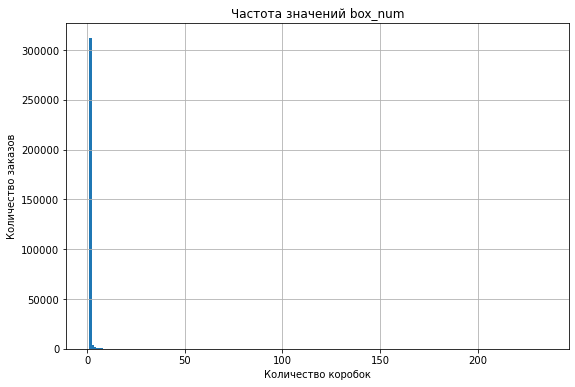

In [25]:
#посмотрим на частоту значений для box_num
data_new['box_num'].hist(bins=200, figsize=(9,6));

plt.xlabel('Количество коробок')
plt.ylabel('Количество заказов')
plt.title('Частота значений box_num');

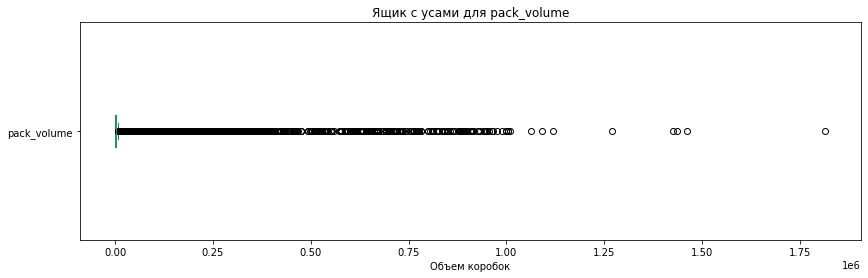

In [26]:
#выведем диаграмму boxplot
data_new['pack_volume'].plot(kind='box', vert=False, figsize=(14,4))

plt.xlabel('Объем коробок')
plt.title('Ящик с усами для pack_volume');

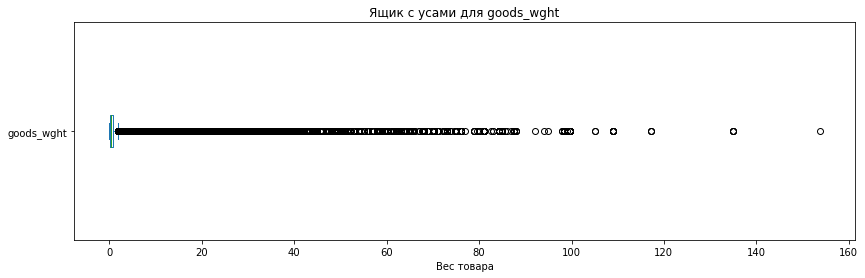

In [27]:
#выведем диаграмму boxplot
data_new['goods_wght'].plot(kind='box', vert=False, figsize=(14,4))

plt.xlabel('Вес товара')
plt.title('Ящик с усами для goods_wght');

Очевидно, что для признаков box_num, pack_volume и goods_wght характерны значительные выбросы. В данных встречаются заказы с очень большим весом, объемом коробки и количеством коробок. Учтем наличие выбросов при обучении модели.

Далее приступим к объединению датасетов.

In [28]:
#удалим лишние столбцы
df_one = data.drop(['whs',
                'who',
                'recommended_carton',
                'recommended_cartontype',
                'selected_cartontype',
                'trackingid',
                'rec_calc_cube',
                'sel_calc_cube'], axis=1)

В качестве таргета выступает исторически выбранная коробка, значит необходимо отталкиваться именно от того, что положили в одну коробку, а не в заказ. Поэтому создадим уникальный признак номер заказа + номер коробки и избавимся от от них в отдельности.

In [29]:
#создадим новый признак
df_one['box_id'] = df_one['orderkey'] + df_one['box_num'].astype(str)

In [30]:
#удалим лишнее
df_one = df_one.drop(['box_num', 'orderkey', 'pack_volume'], axis=1)

Далее создадим отдельный датасет с наименованием выбранной коробки для заказа. Это будет таргет.

In [31]:
#выделим ключ и таргет в отдельный датасет
target = df_one[['selected_carton', 'box_id']]

#удалим дублирующиеся номера заказа
target = target.drop_duplicates(subset='box_id', keep="first").reset_index(drop=True)

#посмотрим на результат
target.head(10)

,selected_carton,box_id
0,NONPACK,d48f3211c1ffccdc374f23139a9ab6681
1,STRETCH,4b33fcc98ea1f59d6fe4eb2e0a48bb4b1
2,STRETCH,3e646181f6f708edd3326c1626c12d231
3,STRETCH,7047c16a6b7c120162ca3da0ebca43fd1
4,STRETCH,097917e584151c0c21f205b2c3aafa101
5,NONPACK,1d11d793924acefde0b7f2ad149e1b451
6,NONPACK,abea12f00a205457b289b2e5c0351e171
7,STRETCH,36c08c84db8a36ce66e3893be0efcd811
8,STRETCH,25ada3fea95cadbcba7b8e6e90ee8ccd1
9,MYC,5a5f8c06487c426283b5c587282816471


In [32]:
#создадим вспомогательный датафрейм
unique_sku_in_data =  df_one['sku'].drop_duplicates().reset_index(drop=True)

In [33]:
#объединим данные
df_two = pd.merge(unique_sku_in_data, sku, how='left', on='sku')
df_two = pd.merge(df_two, sku_cargotypes, how='left', on='sku')

In [34]:
#преименуем столбец 
df_two = df_two.rename(columns={'cargotype': 'cargotypes'})

Создадим функцию для преобразования карготипов и трансформации датафрейма.

In [35]:
#создадим функцию для преобразования датасета
def make_type_rows(df):

    pivoted = pd.pivot_table(df.assign(val=1), values='val', index=['sku'], columns=['cargotypes'], 
                                 aggfunc=lambda x: 1, fill_value=0)
    pivoted.columns = ['type_' + str(x) if x!='sku' else x for x in pivoted.columns]
    #сбросим индексы
    pivoted_def = pivoted.reset_index()
    
    return pivoted_def

def merge_pivoted(df):
    
    pivoted = make_type_rows(df)
    df = pd.merge(df, pivoted, on=['sku'])
    df = df.drop(['cargotypes'], axis=1)
    df = df.drop_duplicates()
    
    return df

In [36]:
#создадим новый признак с объемом товара
def feature_volume(df):
    df['volume'] = df['a'] * df['b'] * df['c']
    return df

In [37]:
# создадим новые признаки используя вычисления групповых статистик
def new_group_features(df):

    def size_ratio(x, y, z):
        return x * y * z / (x + y + z + 1e-3)

    groups = {
        'goods_wght': ['mean'],
        'volume': ['mean', 'max', 'min'],
        'a': ['mean', 'max', 'min'],
        'b': ['mean', 'max', 'min'],
        'c': ['mean', 'max', 'min'],
    }


    grouped = df.groupby(['box_id']).agg(groups)

    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped = grouped.reset_index()

    grouped['size'] = df.apply(lambda row: size_ratio(row['a'], row['b'], row['c']), axis=1)
    
    return grouped

In [38]:
# создадим новые признаки 
def new_features_log(df):

    def size_ratio(x, y, z):
        return x * y * z / (x + y + z + 1e-3)

    df['size'] = df.apply(lambda row: size_ratio(row['a'], row['b'], row['c']), axis=1)
    
    return df

In [39]:
# создадим новые признаки 
def new_features_log(df):

    def size_ratio(x, y, z):
        return x * y * z / (x + y + z + 1e-3)

    df['size'] = df.apply(lambda row: size_ratio(row['a'], row['b'], row['c']), axis=1)
    
    return df

In [40]:
#создадим промежуточный датафрейм
df_three = merge_pivoted(df_two)

In [41]:
#объединим промежуточный датасет
df_four = pd.merge(df_one, df_three, how='left', on='sku')

In [42]:
#применим функцию для сощдания нового столбца
df_four = feature_volume(df_four)

Создадим счетчик количества товаров в заказе.

In [43]:
#создадим новый столбец где кадому sku в заказе ссотвествует 1
df_four['count'] = 1

In [44]:
#создадим временный датасет для преобразований
df_temp = df_four.copy()

In [45]:
#преобразуем временный датасет
df_temp = new_group_features(df_temp)

In [46]:
#сгруппируем все sku по номеру заказа/коробки
df_four = df_four.groupby('box_id').sum()

In [47]:
#перенесем номер индекс
df_four['box_id'] = df_four.index

In [48]:
#избавимся от мультииндекса
df_four = df_four.reset_index(drop=True)

In [49]:
#объединим финальный датасет
df_raw = pd.merge(df_four, df_temp, how='left', on='box_id')

In [50]:
#присодеиним таргет по номеру заказа
df_raw = pd.merge(df_raw, target, how='left', on='box_id')

In [51]:
#применим функцию
df_raw = new_features_log(df_raw)

In [52]:
#удалим лишний столбец
df_raw = df_raw.drop('sku', axis=1)

In [53]:
#посмотрим на результат
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170561 entries, 0 to 170560
Columns: 104 entries, selected_carton_x to selected_carton_y
dtypes: float64(99), int64(1), object(4)
memory usage: 135.3+ MB


Теперь датасет для обучения сгруппирован по номеру заказа/коробки и содержит агрегированные признаки по всем sku для каждого заказа.

In [54]:
#для некоторых заказов нет данных о товарах, заполним пропущенные значения нулями
df_raw = df_raw.fillna(0)

In [55]:
#удалим лишние столбцы
df_raw = df_raw.drop(['box_id', 
                      'selected_carton_x', 
                      'cartontype'],
                      axis=1)

In [56]:
#переименуем для удобства столбец
df_raw = df_raw.rename(columns={'selected_carton_y': 'package'})

In [95]:
#проверим результат
df_raw.sample(5)

,goods_wght,a,b,c,type_0.0,type_20.0,type_40.0,type_81.0,type_110.0,type_120.0,type_130.0,type_140.0,type_160.0,type_200.0,type_210.0,type_290.0,type_291.0,type_292.0,type_300.0,type_301.0,type_302.0,type_303.0,type_305.0,type_310.0,type_315.0,type_320.0,type_330.0,type_340.0,type_350.0,type_360.0,type_400.0,type_410.0,type_440.0,type_441.0,type_460.0,type_480.0,type_485.0,type_490.0,type_510.0,type_520.0,type_600.0,type_601.0,type_610.0,type_611.0,type_620.0,type_621.0,type_622.0,type_623.0,type_640.0,type_641.0,type_670.0,type_671.0,type_672.0,type_673.0,type_690.0,type_691.0,type_692.0,type_710.0,type_720.0,type_750.0,type_751.0,type_770.0,type_780.0,type_790.0,type_799.0,type_801.0,type_900.0,type_901.0,type_905.0,type_908.0,type_910.0,type_911.0,type_920.0,type_930.0,type_931.0,type_950.0,type_955.0,type_960.0,type_970.0,type_980.0,type_990.0,type_1010.0,type_1011.0,type_1300.0,volume,count,goods_wght_mean,volume_mean,volume_max,volume_min,a_mean,a_max,a_min,b_mean,b_max,b_min,c_mean,c_max,c_min,size,package
137032,2.135,26.0,13.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5070.000,1,2.135,5070.0000,5070.000,5070.000,26.00,26.0,26.0,13.00,13.0,13.0,15.00,15.0,15.0,93.887150,YMC
12237,0.876,15.9,30.3,14.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1693.101,2,0.438,846.5505,904.365,788.736,7.95,8.1,7.8,15.15,15.8,14.5,7.05,7.7,6.4,112.650818,YMA
170524,0.160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1,0.160,0.0000,0.000,0.000,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,MYB
90160,1.504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1,1.504,0.0000,0.000,0.000,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,NONPACK
78615,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1,1.000,0.0000,0.000,0.000,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,MYB


Далее сделаем еще один датасет для анализа данных.

In [58]:
# объединим признаки
df1 = pd.merge(data_new, sku, how='left', on='sku')

#продублируем датасет
df = df1.copy()

In [59]:
#уберем ненужные столбцы
df = df.drop(['whs',
                'who',
                'trackingid',
                'rec_calc_cube'], axis=1)

In [60]:
#заменим названия столбцов для исследования
carton = carton.rename(columns={'cartontype': 'carton'})
df = df.rename(columns={'cartontype': 'carton'})

In [61]:
#присоединим необходимые для анализа признаки
df = pd.merge(df, carton, how='left', on='carton')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325623 entries, 0 to 325622
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   orderkey       325623 non-null  object 
 1   box_num        325623 non-null  int64  
 2   sel_calc_cube  325623 non-null  int64  
 3   pack_volume    325623 non-null  int64  
 4   goods_wght     325623 non-null  float64
 5   sku            325623 non-null  object 
 6   carton         325623 non-null  object 
 7   a              314830 non-null  float64
 8   b              314830 non-null  float64
 9   c              314830 non-null  float64
 10  length         325621 non-null  float64
 11  width          325621 non-null  float64
 12  height         325621 non-null  float64
 13  displayrfpack  325621 non-null  float64
dtypes: float64(8), int64(3), object(3)
memory usage: 34.8+ MB


## Исследовательский анализ данных

Вернемся к исходным датасетам и исследуем взаимосвязи в данных.

carton
MYB        0.171785
MYC        0.149980
NONPACK    0.093657
YMC        0.083376
MYD        0.075741
YMG        0.072507
MYA        0.062652
YMF        0.059136
YMW        0.058881
YMA        0.048507
YME        0.038956
STRETCH    0.038280
MYE        0.029847
YML        0.010079
MYF        0.004146
YMX        0.002463
YMB        0.000006
Name: proportion, dtype: float64


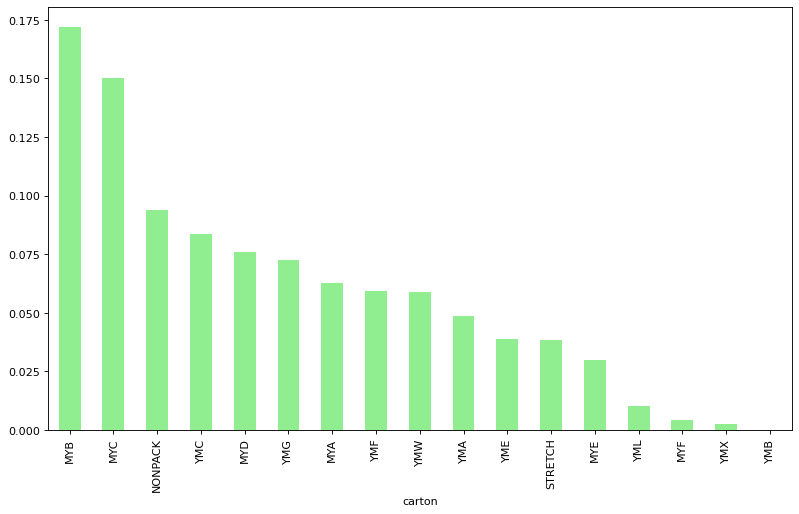

In [63]:
#исследуем баланс классов

plt.figure(figsize=(12,7), dpi= 80)

#относительная частота значений от 0 до 1
class_frequency = df['carton'].value_counts(normalize=True)

#выведем относительное количество данных в двух классах
print(class_frequency)

#для наглядности выведем диаграмму
class_frequency.plot(kind='bar', color='lightgreen');

Можно заметить существенный дисбаланс классов. Например, для типа упаковки YMB встречается одно значение. При обучении это может помешать.

interval columns not set, guessing: ['box_num', 'sel_calc_cube', 'pack_volume', 'goods_wght', 'a', 'b', 'c', 'length', 'width', 'height']


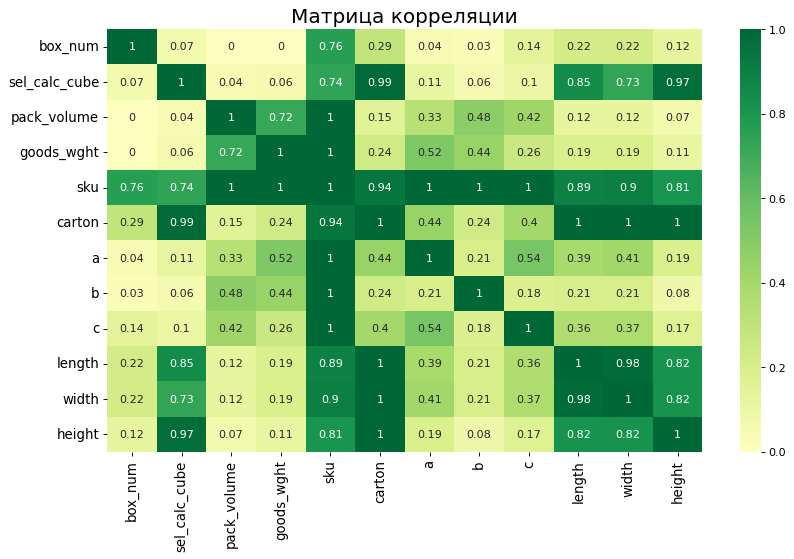

In [64]:
#отобразим матрицу корреляции для всех признаков

columns = ['box_num', 'sel_calc_cube', 
           'pack_volume', 'goods_wght', 
           'sku', 'carton', 'a', 'b', 
           'c', 'length', 'width', 'height']


plt.figure(figsize=(12,7), dpi= 80)

sns.heatmap(df[columns].phik_matrix().round(2),
            xticklabels=columns, 
            yticklabels=columns, 
            cmap='RdYlGn', 
            center=0, 
            annot=True)

#выведем результат
plt.title('Матрица корреляции', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
None

На матрице можно заметить высокие значения корреляции carton с признаками размеров товара (a, b, c) и веса. Признаки из исторических данных не представляют большой ценности в контексте будущего обучения.

In [65]:
#проперим количество уникальных значений
carton['carton'].value_counts().count()

29

In [66]:
#проперим количество уникальных значений
df['carton'].value_counts().count()

17

Изначально в файле carton 29 типов упаковки, из них используется лишь 17.

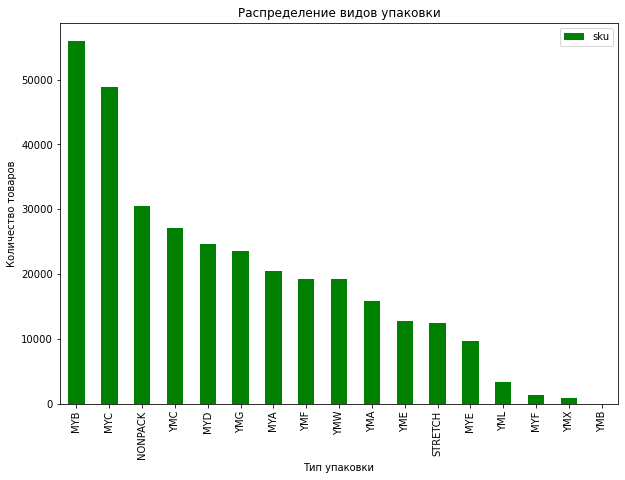

In [67]:
#сгруппируем ушедших клиентов по типу подписки
t = (df.pivot_table(index='carton', values='sku', aggfunc='count')
      .sort_values(by=['sku'], ascending=False)
      .plot(kind='bar', figsize= (10,7), color='green'));

plt.xlabel('Тип упаковки')
plt.ylabel('Количество товаров')
plt.title('Распределение видов упаковки');

В наших данных 'MYA', 'MYB', 'MYC', 'MYD', 'MYE' - это пакеты. Чаще всего предпочтение отдается пакету, либо товар не запаковывается вообще.

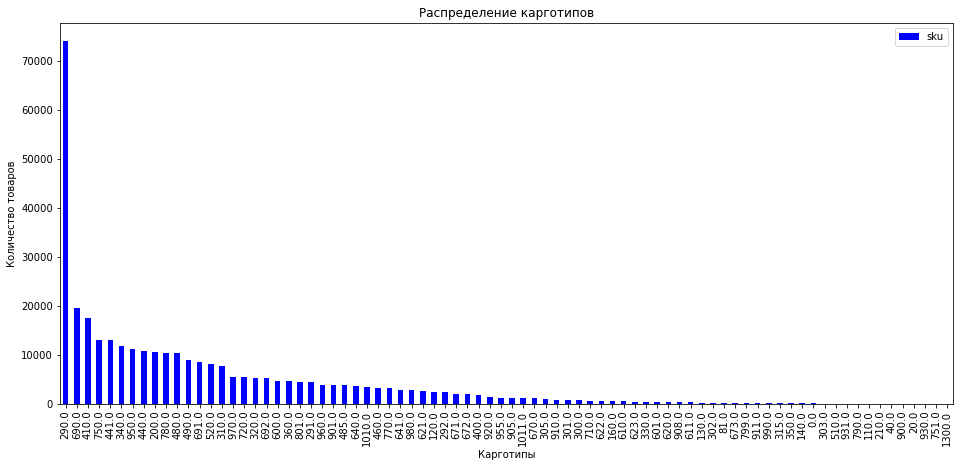

In [68]:
#сгруппируем ушедших клиентов по типу подписки
s = (df_two.pivot_table(index='cargotypes', values='sku', aggfunc='count')
      .sort_values(by=['sku'], ascending=False)
      .plot(kind='bar', figsize= (16,7), color='blue'))

plt.xlabel('Карготипы')
plt.ylabel('Количество товаров')
plt.title('Распределение карготипов');

In [69]:
#посмотрим на самый частовстречающийся карготип
cargotype_info[cargotype_info['cargotype'] == 290.0]

,cargotype,description
66,290,Склад МГТ (малогабаритный товар)


Можно сделать предположение, что чаще всего в заказе встречается малогабаритный товар, который упаковывается в пакет.

In [70]:
#выведем наиболее часто встречающееся количество коробок
df['box_num'].value_counts().head(10)

box_num
1     296683
2      15199
3       4311
4       1739
5        981
6        503
7        431
10       267
8        248
12       212
Name: count, dtype: int64

Две и более коробки для одного заказа встречаются довольно часто.

Далее выполним несколько группировок, чтобы узнать процент заказов с одним товаром

In [71]:
#выполним группировку по заказу
order_counts = df[['orderkey', 'sku']].groupby(['orderkey']).count()

#выделим заказы с одним товаром
single_item_orders = order_counts[order_counts['sku'] == 1]

#создадим список заказов с одним товаром 
single_item_order_ids = single_item_orders.index.tolist()

#создадим новый датасет
one_sku = df[['orderkey', 'sku']]

#отфильтруем заказы с одним товаром
one_sku = df[df['orderkey'].isin(single_item_order_ids)]

In [72]:
#посмотрим на размер
one_sku.shape

(103970, 14)

In [73]:
#определим процент с заказов с одним товаром
one_sku.shape[0]  / df['orderkey'].nunique()

0.6502229532392323

В 65% заказов один товар. Это больше половины заказов в целом по исходным данным.

Далее посмотрим на распределение заказов по количеству товаров.

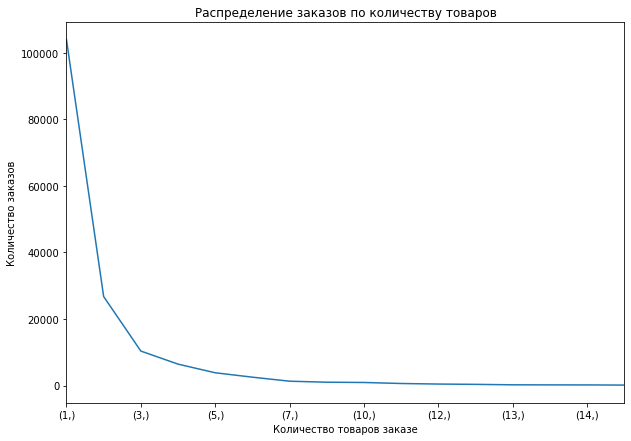

In [74]:
#посчитаем количество заказов
order_counts = df[['orderkey', 'sku']].groupby(['orderkey']).count()

#выведем количество
order_counts.value_counts()

#выведем количество на графике
order_counts.value_counts().plot(xlim=(0,15),
                                 figsize= (10,7))

plt.xlabel('Количество товаров заказе')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по количеству товаров');

На графике видно правильное распределение количества заказов в товаре, никаких пиков.

In [75]:
#посмотрим на количество уникальных заказов
df['orderkey'].nunique()

159899

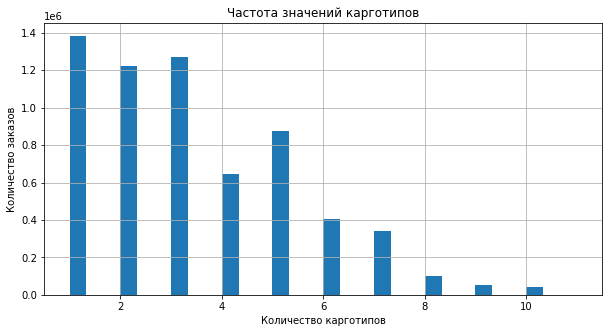

In [76]:
#посмотрим количество карготипов для каждого товара
(sku_cargotypes
 .groupby('sku')['cargotype']
 .count()
 .reset_index()
 .hist(bins=30, figsize=(10,5)))


plt.xlabel('Количество карготипов')
plt.ylabel('Количество заказов')
plt.title('Частота значений карготипов');

Чаще всего для одного товара бывает 1 или 2 карготипа. Но бывает и больше.

Далее посмотрим, насколько часто выбор упаковщиков отличается для одного и того же товара.

In [77]:
#удалим ненужные столбцы
one_sku = one_sku.drop(['orderkey', 'box_num'], axis=1)

In [78]:
#оставим только уникальные сочетания товара и упаковки
carton_counts = one_sku.drop_duplicates(subset=['carton', 'sku'])

#Сгруппируем по товару, чтобы посчитать количество вариантов упаковки
sku_carton = (carton_counts.groupby('sku')['carton']
              .count()
              .sort_values(ascending=False)
              .reset_index())

#посчитаем долю заказов
sku_carton[sku_carton['carton'] == 1].shape[0] / sku_carton.shape[0] 

0.8167717008027608

В 82 % заказов с одним товаром упаковщики всегда выбирали 1 вариант упаковки.

In [79]:
#выведем различные варианты упаковки одного товара
check_sku = one_sku[one_sku['sku'] == 'bd96ee8a131321f5c6d99aba4d778eed']

check_sku.groupby(['carton', 'pack_volume', 'a', 'b',
       'c', 'length', 'width', 'height'])['carton'].count()

carton   pack_volume  a     b    c     length  width  height
MYA      5698         37.0  7.0  22.0  15.0    20.0   3.33        6
MYB      5698         37.0  7.0  22.0  22.0    32.0   4.90       16
MYC      5698         37.0  7.0  22.0  30.0    38.0   7.40      211
MYD      5698         37.0  7.0  22.0  38.0    50.0   8.20       85
MYE      5698         37.0  7.0  22.0  43.0    63.0   9.70        4
NONPACK  5698         37.0  7.0  22.0  0.0     0.0    0.00       20
STRETCH  5698         37.0  7.0  22.0  0.0     0.0    0.00        1
YMC      5698         37.0  7.0  22.0  30.0    20.0   15.00       1
YMF      5698         37.0  7.0  22.0  35.0    25.0   15.00       5
YMG      5698         37.0  7.0  22.0  44.7    30.0   20.00       9
YMW      5698         37.0  7.0  22.0  40.0    30.0   15.00      11
Name: carton, dtype: int64

В таблице выше показаны различные варианты упаковки одного товара, в последнем столбце количество раз ее использования. На примере этой sku видно, что наиболее часто используемая упаковка подходит по размерам наилучшим образом. Если размеры товара верны, сложно представить как упаковщики положили в sku в меньшие коробки.

Кроме того, можно резюмировать следующие гипотезы:

- чаще всего в заказе встречается малогабаритный товар, который упаковывается в пакет;
- в 65% заказов содержится только один товар;
- в 82% заказов с одним товаром упаковщики всегда выбирали 1 вариант упаковки.


Для обучения модели выбрана концепция генерации новых признаков на основе поступающих из запроса данных.

## Обучение модели

In [80]:
#создадим датасет с признаками
X = df_raw.drop(['package'], axis=1)

In [81]:
#выделем таргет
y = df_raw['package']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True,
        test_size=0.25, 
        stratify=None, 
        random_state=22)

In [83]:
#посмотрим на результат деления
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(127920, 100)
(127920,)
(42641, 100)
(42641,)


In [84]:
#отсротируем столбцы
X_train.sort_index(axis=1, inplace=True)

In [85]:
#посмотрим сколько классов содержится в таргете
len(set(y_train))

17

In [86]:
#зададим метрики
scoring = ['accuracy','f1_macro']

In [87]:
#создадим список столбцов для масштабирования
num_features = list(X_train.select_dtypes(exclude=['object']).columns.values.tolist())

print(num_features)

['a', 'a_max', 'a_mean', 'a_min', 'b', 'b_max', 'b_mean', 'b_min', 'c', 'c_max', 'c_mean', 'c_min', 'count', 'goods_wght', 'goods_wght_mean', 'size', 'type_0.0', 'type_1010.0', 'type_1011.0', 'type_110.0', 'type_120.0', 'type_130.0', 'type_1300.0', 'type_140.0', 'type_160.0', 'type_20.0', 'type_200.0', 'type_210.0', 'type_290.0', 'type_291.0', 'type_292.0', 'type_300.0', 'type_301.0', 'type_302.0', 'type_303.0', 'type_305.0', 'type_310.0', 'type_315.0', 'type_320.0', 'type_330.0', 'type_340.0', 'type_350.0', 'type_360.0', 'type_40.0', 'type_400.0', 'type_410.0', 'type_440.0', 'type_441.0', 'type_460.0', 'type_480.0', 'type_485.0', 'type_490.0', 'type_510.0', 'type_520.0', 'type_600.0', 'type_601.0', 'type_610.0', 'type_611.0', 'type_620.0', 'type_621.0', 'type_622.0', 'type_623.0', 'type_640.0', 'type_641.0', 'type_670.0', 'type_671.0', 'type_672.0', 'type_673.0', 'type_690.0', 'type_691.0', 'type_692.0', 'type_710.0', 'type_720.0', 'type_750.0', 'type_751.0', 'type_770.0', 'type_780.0

In [88]:
#зададим параметры для поиска
param_search_lgb = {'model__max_depth': [10, 12, 14],
                    'model__learning_rate': [0.1, 0.2],
                     'model__num_leaves': [30, 50, 60]}

#определим постоянные параметры модели
params_lgb = {
    'objective': 'multiclass',
    'num_class':17,
    'metric': 'multi_logloss',
    'n_estimators': 500,
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE}

#объявим модель
model_lgb = LGBMClassifier(**params_lgb)

#создадим пайплайн 
pipline_lgb = Pipeline(steps=[('scaler', StandardScaler()),
                              ('model', model_lgb)])

#определим поиск оптимальных параметров и обучение
gs_lgb = RandomizedSearchCV(estimator=pipline_lgb, 
                     cv=5, 
                     param_distributions=param_search_lgb,
                     refit='accuracy',
                     scoring= scoring,
                     n_jobs=-1)

#обучим модель
gs_lgb.fit(X_train, y_train)

#сохраним лучшие результаты
gs_lgb_best_score = gs_lgb.best_score_ 
gs_lgb_best_params = gs_lgb.best_params_

#выведем результаты обучения
print(f'best_score: {gs_lgb_best_score}')
print(f'best_params: {gs_lgb_best_params}')

best_score: 0.48451375859912443
best_params: {'model__num_leaves': 50, 'model__max_depth': 14, 'model__learning_rate': 0.1}


'best_score: 0.3753388291481426\nbest_params: {\'model__num_leaves\': 60, \'model__max_depth\': 10, \'model__learning_rate\': 0.1}\n"best_score: 0.3758254378119532\nbest_params: {\'model__num_leaves\': 50, \'model__max_depth\': 10, \'model__learning_rate\': 0.1}"'

In [96]:
#сохраним лучшую модель
model_lgbm = gs_lgb.best_estimator_

with open('model_lgbm_v4.pcl', 'bw') as fid:
    pickle.dump(model_lgbm, fid) 

In [97]:
#зададим функцию для вывода интересующих метрик
def results_gm(model):
    
    results = pd.DataFrame(model.cv_results_)
    table_results = (results[['mean_test_f1_macro', 'mean_test_accuracy']].round(3).head(5)
                     .sort_values(by='mean_test_f1_macro', ascending=False))
    
    return table_results

In [98]:
results = results_gm(gs_lgb)
results

,mean_test_f1_macro,mean_test_accuracy
4,0.376,0.485
1,0.313,0.440
2,0.305,0.393
0,0.106,0.201
3,0.098,0.152


На данном этапе модель выдает не очень хорошие предсказания. Метрика f1 показывает низкие значения. 

## Тестирование модели

In [99]:
# выполним тестирование модели
predicted_test = model_lgbm.predict(X_test)

In [100]:
#выведем отчет
print(classification_report(y_test, predicted_test))

              precision    recall  f1-score   support

         MYA       0.13      0.08      0.10      4049
         MYB       0.24      0.52      0.33     10310
         MYC       0.07      0.00      0.00      7681
         MYD       0.27      0.06      0.10      3447
         MYE       0.03      0.03      0.03      1211
         MYF       0.00      0.00      0.00       228
     NONPACK       0.13      0.29      0.18      5819
     STRETCH       0.30      0.02      0.04      2559
         YMA       0.04      0.00      0.00      1730
         YMC       0.03      0.03      0.03      2045
         YME       0.00      0.00      0.00       395
         YMF       0.05      0.01      0.01      1096
         YMG       0.00      0.00      0.00       975
         YML       0.00      0.00      0.00        44
         YMW       0.20      0.00      0.00      1022
         YMX       0.00      0.00      0.00        30

    accuracy                           0.18     42641
   macro avg       0.09   

## Вывод

В результате разработки алгоритма выполнены следующие этапы:
1. задан параметр RANDOM_STATE = 42;
2. изучены данные;
3. выполнена предобработка;
4. проведен ислледовательский анализ данных;
5. разработаны функции для генерации новых признаков;
6. разработан пайплайн модели машинного обучения.

В основу алгоритма рекомендации упаковки разработана модель LGBMClassifier со следующими параметрами:
- objective: 'multiclass';
- num_class:17;
- metric': 'multi_logloss';
- num_leaves': 50;
- learning_rate': 0.1;
- n_estimators': 500;
- class_weight': 'balanced';
- max_depth: 14.

При тестировании модели можно увидеть, какие категории предсказваются лучше остальных. Так категории упаковок пакеты MYB и MYC получили чуть более лучшую метрику f1. В случае выбора оптимального размера коробки, более критичной является ошибка первого рода. Ведь если алгоритм предскажет не оптимальную коробку, сотрудник потратит время на выбор другой, возможно неправильно оценит хрупкость и тогда пострадает уже клиент. Поэтому в дальнейшем важно уделить внимание метрике recall.